# Credit Risk Assessment - XGBoost Model (SMOTE-Balanced)

This notebook trains an XGBoost model using **preprocessed data with SMOTE** from the data pipeline.

**What this notebook does:**
1. Load preprocessed data (with SMOTE already applied)
2. Train XGBoost model
3. Optimize classification threshold
4. Calibrate probabilities
5. Evaluate performance

**Data Pipeline Handles:**
- ✅ Data loading
- ✅ Train/val/test splits
- ✅ Preprocessing
- ✅ Feature engineering (12 risk indicators)
- ✅ SMOTE resampling (verified)
- ✅ Saved to `data/processed/`

## 1. Setup and Load Data

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd

from src.data_pipeline import load_processed_data
from src.config import MODELS_DIR, XGBOOST_PARAMS
from src.models.xgboost_model import XGBoostModel
from src.evaluation import ModelEvaluator
from src.utils import setup_logging, set_seed

# Setup
setup_logging()
set_seed(42)

print("✓ Imports successful!")

✓ Imports successful!


In [2]:
print("="*80)
print("LOADING PREPROCESSED DATA (WITH SMOTE)")
print("="*80)

# Load preprocessed data from data pipeline
X_train, y_train, X_val, y_val, X_test, y_test = load_processed_data()

print(f"\n✓ Data loaded successfully!")
print(f"\nDataset sizes:")
print(f"  Training: {len(X_train):,} samples, {X_train.shape[1]} features")
print(f"  Validation: {len(X_val):,} samples")
print(f"  Test: {len(X_test):,} samples")

print(f"\nTraining set class distribution (SMOTE-balanced):")
train_dist = y_train.value_counts().sort_index()
print(f"  Class 0 (good): {train_dist[0]:,} ({train_dist[0]/len(y_train)*100:.1f}%)")
print(f"  Class 1 (bad): {train_dist[1]:,} ({train_dist[1]/len(y_train)*100:.1f}%)")
print(f"  Imbalance ratio: {train_dist[0]/train_dist[1]:.2f}:1")

print(f"\nValidation set class distribution (original):")
val_dist = y_val.value_counts().sort_index()
print(f"  Class 0 (good): {val_dist.iloc[0]:,} ({val_dist.iloc[0]/len(y_val)*100:.1f}%)")
print(f"  Class 1 (bad): {val_dist.iloc[1]:,} ({val_dist.iloc[1]/len(y_val)*100:.1f}%)")
print(f"  Imbalance ratio: {val_dist.iloc[0]/val_dist.iloc[1]:.2f}:1")

INFO:src.data_pipeline:Loading processed data...


LOADING PREPROCESSED DATA (WITH SMOTE)


INFO:src.data_pipeline:✓ Training data (SMOTE-balanced): (364313, 103)
INFO:src.data_pipeline:✓ Validation data: (75000, 103)
INFO:src.data_pipeline:✓ Test data: (100000, 103)



✓ Data loaded successfully!

Dataset sizes:
  Training: 364,313 samples, 103 features
  Validation: 75,000 samples
  Test: 100,000 samples

Training set class distribution (SMOTE-balanced):
  Class 0 (good): 260,224 (71.4%)
  Class 1 (bad): 104,089 (28.6%)
  Imbalance ratio: 2.50:1

Validation set class distribution (original):
  Class 0 (good): 60,052 (80.1%)
  Class 1 (bad): 14,948 (19.9%)
  Imbalance ratio: 4.02:1


## 2. Train XGBoost Model

In [3]:
print("="*80)
print("TRAINING XGBOOST MODEL ON SMOTE-BALANCED DATA")
print("="*80)

# Prepare parameters
params = XGBOOST_PARAMS.copy()

# Adjust scale_pos_weight for SMOTE-balanced data
params['scale_pos_weight'] = train_dist[0] / train_dist[1]

print(f"\nModel parameters:")
print(f"  scale_pos_weight: {params['scale_pos_weight']:.2f}")
print(f"  learning_rate: {params['learning_rate']}")
print(f"  max_depth: {params['max_depth']}")
print(f"  n_estimators: {params['n_estimators']}")

print(f"\nTraining model...\n")

# Train model
xgb_model = XGBoostModel(params=params)
xgb_model.train(
    X_train, y_train,  # SMOTE-balanced training data
    X_val, y_val,      # Original validation data
    verbose=True
)

# Save model
model_path = MODELS_DIR / 'xgboost_smote_improved.pkl'
xgb_model.save_model(model_path)
print(f"\n✓ Model saved to {model_path}")

2025-12-08 00:29:22,672 - credit_risk_fyp.models.xgboost - INFO - Training XGBoost model...
INFO:credit_risk_fyp.models.xgboost:Training XGBoost model...
2025-12-08 00:29:22,676 - credit_risk_fyp.models.xgboost - INFO - Training set size: 364,313 samples, 103 features
INFO:credit_risk_fyp.models.xgboost:Training set size: 364,313 samples, 103 features
2025-12-08 00:29:22,691 - credit_risk_fyp.models.xgboost - INFO - Class distribution - 0: 260,224, 1: 104,089
INFO:credit_risk_fyp.models.xgboost:Class distribution - 0: 260,224, 1: 104,089
2025-12-08 00:29:22,696 - credit_risk_fyp.models.xgboost - INFO - Scale pos weight: 2.5000
INFO:credit_risk_fyp.models.xgboost:Scale pos weight: 2.5000


TRAINING XGBOOST MODEL ON SMOTE-BALANCED DATA

Model parameters:
  scale_pos_weight: 2.50
  learning_rate: 0.05
  max_depth: 8
  n_estimators: 1000

Training model...



2025-12-08 00:29:23,688 - credit_risk_fyp.models.xgboost - INFO - Validation set size: 75,000 samples
INFO:credit_risk_fyp.models.xgboost:Validation set size: 75,000 samples


[0]	train-auc:0.75868	val-auc:0.64646
[50]	train-auc:0.83301	val-auc:0.71402
[100]	train-auc:0.84813	val-auc:0.72235
[150]	train-auc:0.85898	val-auc:0.72507
[200]	train-auc:0.86771	val-auc:0.72651
[250]	train-auc:0.87632	val-auc:0.72734
[300]	train-auc:0.88440	val-auc:0.72731
[350]	train-auc:0.89167	val-auc:0.72759
[384]	train-auc:0.89693	val-auc:0.72751


2025-12-08 00:31:33,703 - credit_risk_fyp.models.xgboost - INFO - [OK] Training complete. Best iteration: 334
INFO:credit_risk_fyp.models.xgboost:[OK] Training complete. Best iteration: 334
2025-12-08 00:31:33,708 - credit_risk_fyp.models.xgboost - INFO - [OK] Validation AUC: 0.7277
INFO:credit_risk_fyp.models.xgboost:[OK] Validation AUC: 0.7277
2025-12-08 00:31:33,841 - credit_risk_fyp.models.xgboost - INFO - Saved XGBoost model to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl
INFO:credit_risk_fyp.models.xgboost:Saved XGBoost model to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl


✓ Saved object to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl

✓ Model saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl


## 3. Make Predictions

In [4]:
print("Making predictions...")

y_val_proba = xgb_model.predict_proba(X_val)
y_test_proba = xgb_model.predict_proba(X_test)

print(f"\n✓ Validation predictions: {len(y_val_proba):,}")
print(f"✓ Test predictions: {len(y_test_proba):,}")

Making predictions...

✓ Validation predictions: 75,000
✓ Test predictions: 100,000


## 4. Optimize Classification Threshold

In [5]:
print("="*80)
print("OPTIMIZING CLASSIFICATION THRESHOLD")
print("="*80)

evaluator = ModelEvaluator()

# Find optimal thresholds for different metrics
print("\nFinding optimal thresholds on validation set:\n")

optimal_thresholds = {}
for metric in ['f1', 'precision', 'recall']:
    threshold, score = evaluator.optimize_threshold(
        y_val, y_val_proba, metric=metric
    )
    optimal_thresholds[metric] = threshold
    print(f"{metric.upper():<15} Optimal threshold: {threshold:.4f}, Score: {score:.4f}")

# Use F1-optimized threshold as default
optimal_threshold = optimal_thresholds['f1']
print(f"\n✓ Using F1-optimized threshold: {optimal_threshold:.4f}")

OPTIMIZING CLASSIFICATION THRESHOLD

Finding optimal thresholds on validation set:



2025-12-08 00:31:36,457 - credit_risk_fyp.evaluation - INFO - Optimal threshold for f1: 0.3838 (score: 0.4425)
INFO:credit_risk_fyp.evaluation:Optimal threshold for f1: 0.3838 (score: 0.4425)


F1              Optimal threshold: 0.3838, Score: 0.4425


2025-12-08 00:31:37,976 - credit_risk_fyp.evaluation - INFO - Optimal threshold for precision: 0.9192 (score: 1.0000)
INFO:credit_risk_fyp.evaluation:Optimal threshold for precision: 0.9192 (score: 1.0000)


PRECISION       Optimal threshold: 0.9192, Score: 1.0000


2025-12-08 00:31:39,591 - credit_risk_fyp.evaluation - INFO - Optimal threshold for recall: 0.0000 (score: 1.0000)
INFO:credit_risk_fyp.evaluation:Optimal threshold for recall: 0.0000 (score: 1.0000)


RECALL          Optimal threshold: 0.0000, Score: 1.0000

✓ Using F1-optimized threshold: 0.3838


## 5. Probability Calibration

In [6]:
print("="*80)
print("PROBABILITY CALIBRATION (ISOTONIC REGRESSION)")
print("="*80)

# Calibrate validation set probabilities
y_val_calibrated, cal_metrics_val = evaluator.calibrate_probabilities(
    y_val, y_val_proba, method='isotonic'
)

print(f"\nValidation Set Calibration Results:")
print(f"  Method: {cal_metrics_val['method']}")
print(f"  Brier Score: {cal_metrics_val['brier_score_before']:.4f} → {cal_metrics_val['brier_score_after']:.4f} "
      f"(improvement: {cal_metrics_val['brier_improvement']:+.4f})")
print(f"  Log Loss: {cal_metrics_val['log_loss_before']:.4f} → {cal_metrics_val['log_loss_after']:.4f} "
      f"(improvement: {cal_metrics_val['log_loss_improvement']:+.4f})")
print(f"  Expected Calibration Error: {cal_metrics_val['ece_before']:.4f} → {cal_metrics_val['ece_after']:.4f} "
      f"(improvement: {cal_metrics_val['ece_improvement']:+.4f})")

# Calibrate test set probabilities
y_test_calibrated, cal_metrics_test = evaluator.calibrate_probabilities(
    y_test, y_test_proba, method='isotonic'
)

print(f"\nTest Set Calibration Results:")
print(f"  Method: {cal_metrics_test['method']}")
print(f"  Brier Score: {cal_metrics_test['brier_score_before']:.4f} → {cal_metrics_test['brier_score_after']:.4f} "
      f"(improvement: {cal_metrics_test['brier_improvement']:+.4f})")
print(f"  Log Loss: {cal_metrics_test['log_loss_before']:.4f} → {cal_metrics_test['log_loss_after']:.4f} "
      f"(improvement: {cal_metrics_test['log_loss_improvement']:+.4f})")
print(f"  Expected Calibration Error: {cal_metrics_test['ece_before']:.4f} → {cal_metrics_test['ece_after']:.4f} "
      f"(improvement: {cal_metrics_test['ece_improvement']:+.4f})")

print(f"\n✓ Probability calibration complete!")

2025-12-08 00:31:39,624 - credit_risk_fyp.evaluation - INFO - Calibrating probabilities using isotonic method...
INFO:credit_risk_fyp.evaluation:Calibrating probabilities using isotonic method...
2025-12-08 00:31:39,743 - credit_risk_fyp.evaluation - INFO - Calibration complete:
INFO:credit_risk_fyp.evaluation:Calibration complete:
2025-12-08 00:31:39,747 - credit_risk_fyp.evaluation - INFO -   Brier score: 0.1637 → 0.1412 (improvement: 0.0225)
INFO:credit_risk_fyp.evaluation:  Brier score: 0.1637 → 0.1412 (improvement: 0.0225)
2025-12-08 00:31:39,753 - credit_risk_fyp.evaluation - INFO -   Log loss: 0.4992 → 0.4435 (improvement: 0.0557)
INFO:credit_risk_fyp.evaluation:  Log loss: 0.4992 → 0.4435 (improvement: 0.0557)
2025-12-08 00:31:39,757 - credit_risk_fyp.evaluation - INFO -   ECE: 0.1345 → 0.0000 (improvement: 0.1345)
INFO:credit_risk_fyp.evaluation:  ECE: 0.1345 → 0.0000 (improvement: 0.1345)
2025-12-08 00:31:39,763 - credit_risk_fyp.evaluation - INFO - Calibrating probabilities 

PROBABILITY CALIBRATION (ISOTONIC REGRESSION)

Validation Set Calibration Results:
  Method: isotonic
  Brier Score: 0.1637 → 0.1412 (improvement: +0.0225)
  Log Loss: 0.4992 → 0.4435 (improvement: +0.0557)
  Expected Calibration Error: 0.1345 → 0.0000 (improvement: +0.1345)


2025-12-08 00:31:39,904 - credit_risk_fyp.evaluation - INFO - Calibration complete:
INFO:credit_risk_fyp.evaluation:Calibration complete:
2025-12-08 00:31:39,908 - credit_risk_fyp.evaluation - INFO -   Brier score: 0.1642 → 0.1419 (improvement: 0.0223)
INFO:credit_risk_fyp.evaluation:  Brier score: 0.1642 → 0.1419 (improvement: 0.0223)
2025-12-08 00:31:39,911 - credit_risk_fyp.evaluation - INFO -   Log loss: 0.5007 → 0.4456 (improvement: 0.0551)
INFO:credit_risk_fyp.evaluation:  Log loss: 0.5007 → 0.4456 (improvement: 0.0551)
2025-12-08 00:31:39,913 - credit_risk_fyp.evaluation - INFO -   ECE: 0.1714 → 0.0000 (improvement: 0.1714)
INFO:credit_risk_fyp.evaluation:  ECE: 0.1714 → 0.0000 (improvement: 0.1714)



Test Set Calibration Results:
  Method: isotonic
  Brier Score: 0.1642 → 0.1419 (improvement: +0.0223)
  Log Loss: 0.5007 → 0.4456 (improvement: +0.0551)
  Expected Calibration Error: 0.1714 → 0.0000 (improvement: +0.1714)

✓ Probability calibration complete!



Generating calibration plots...


2025-12-08 00:31:41,700 - credit_risk_fyp.evaluation - INFO - Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_xgboost_smote_validation.png
INFO:credit_risk_fyp.evaluation:Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_xgboost_smote_validation.png
2025-12-08 00:31:43,263 - credit_risk_fyp.evaluation - INFO - Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_xgboost_smote_test.png
INFO:credit_risk_fyp.evaluation:Calibration curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\calibration_curve_xgboost_smote_test.png


✓ Calibration curves saved


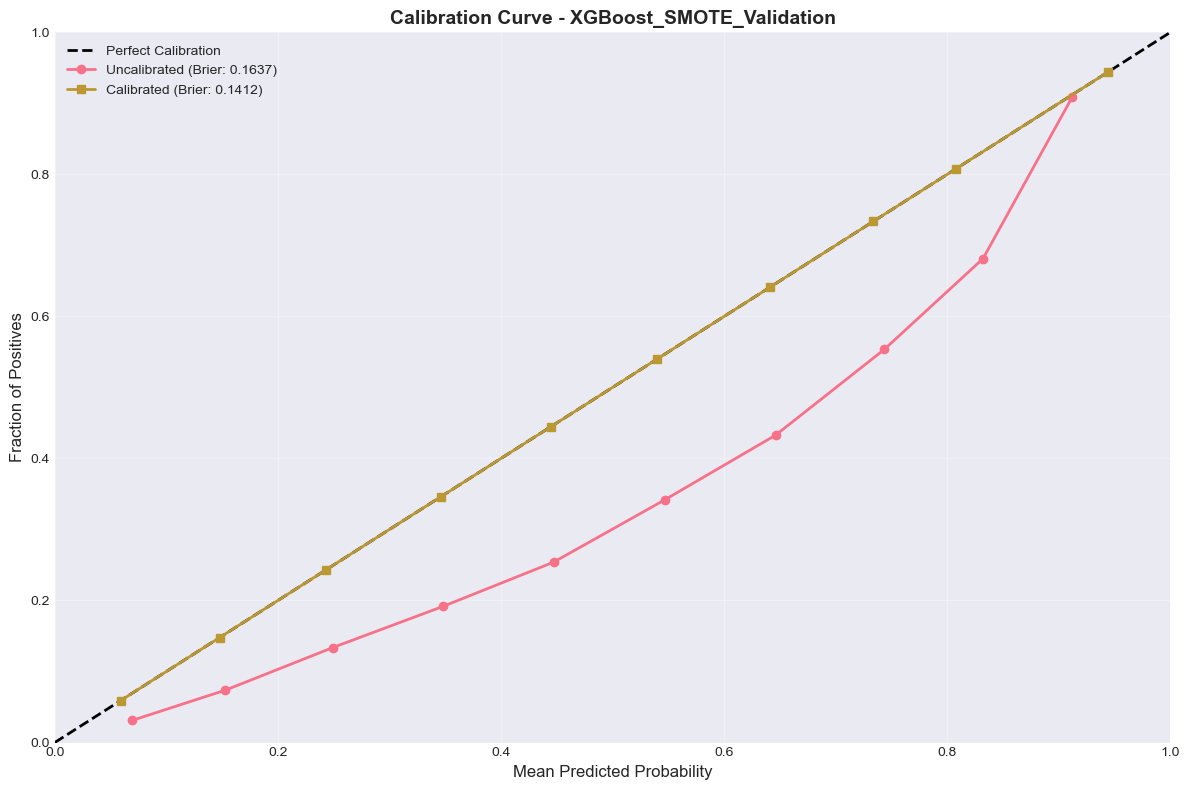

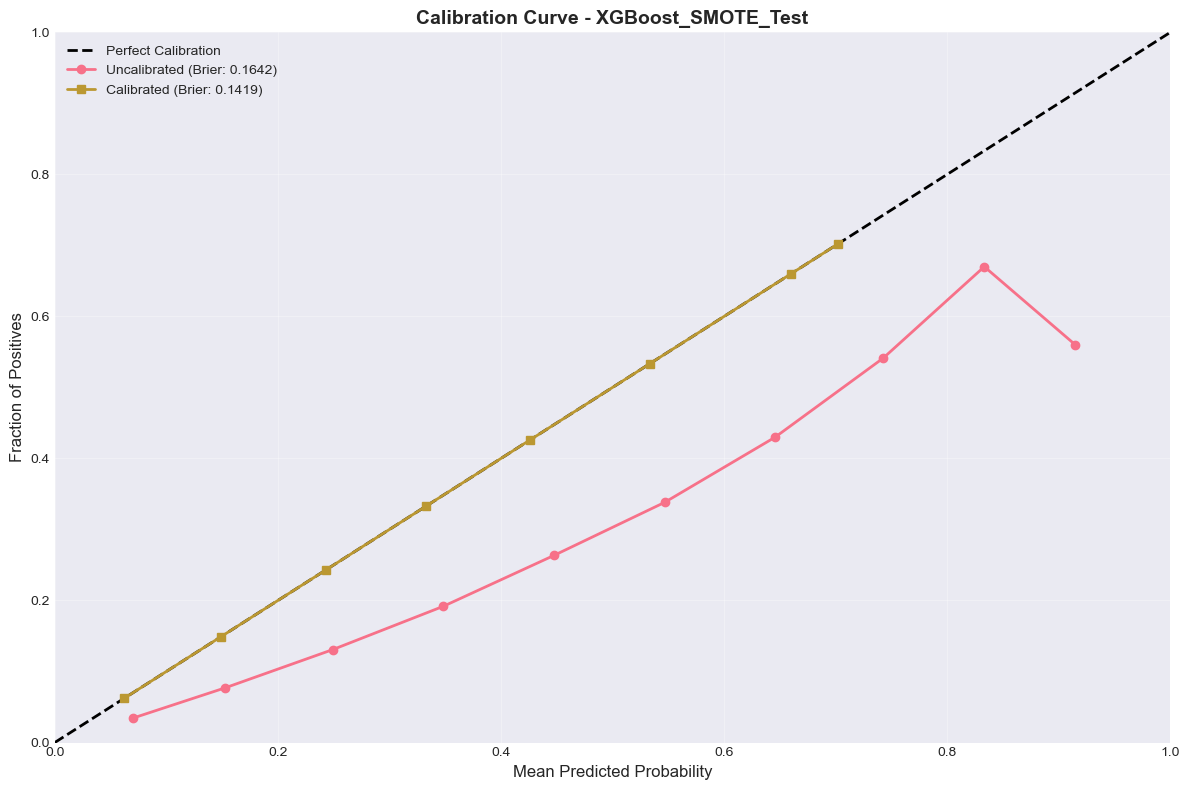

In [7]:
# Plot calibration curves
print("\nGenerating calibration plots...")

# Validation set calibration curve
evaluator.plot_calibration_curve(
    y_val, y_val_proba, y_val_calibrated,
    model_name="XGBoost_SMOTE_Validation",
    n_bins=10,
    save=True
)

# Test set calibration curve
evaluator.plot_calibration_curve(
    y_test, y_test_proba, y_test_calibrated,
    model_name="XGBoost_SMOTE_Test",
    n_bins=10,
    save=True
)

print("✓ Calibration curves saved")

## 6. Evaluate Model (Validation Set)

In [8]:
print("="*80)
print("VALIDATION SET RESULTS")
print("="*80)

val_metrics = evaluator.evaluate(
    y_val, y_val_proba,
    threshold=optimal_threshold,
    model_name="XGBoost_SMOTE_Validation"
)

print("\nKey Metrics:")
print(f"  AUC-ROC: {val_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
print(f"  Precision: {val_metrics['precision']:.4f}")
print(f"  Recall: {val_metrics['recall']:.4f}")
print(f"  F1-Score: {val_metrics['f1_score']:.4f}")
print(f"  PR-AUC: {val_metrics['pr_auc']:.4f}")
print(f"  MCC: {val_metrics['matthews_corr_coef']:.4f}")
print(f"  Cohen's Kappa: {val_metrics['cohen_kappa']:.4f}")

2025-12-08 00:31:44,285 - credit_risk_fyp.evaluation - INFO - Evaluating XGBoost_SMOTE_Validation...
INFO:credit_risk_fyp.evaluation:Evaluating XGBoost_SMOTE_Validation...


VALIDATION SET RESULTS


2025-12-08 00:31:44,492 - credit_risk_fyp.evaluation - INFO - XGBoost_SMOTE_Validation Results:
INFO:credit_risk_fyp.evaluation:XGBoost_SMOTE_Validation Results:
2025-12-08 00:31:44,497 - credit_risk_fyp.evaluation - INFO -   AUC-ROC: 0.7277
INFO:credit_risk_fyp.evaluation:  AUC-ROC: 0.7277
2025-12-08 00:31:44,505 - credit_risk_fyp.evaluation - INFO -   Accuracy: 0.6836
INFO:credit_risk_fyp.evaluation:  Accuracy: 0.6836
2025-12-08 00:31:44,510 - credit_risk_fyp.evaluation - INFO -   Precision: 0.3410
INFO:credit_risk_fyp.evaluation:  Precision: 0.3410
2025-12-08 00:31:44,518 - credit_risk_fyp.evaluation - INFO -   Recall: 0.6301
INFO:credit_risk_fyp.evaluation:  Recall: 0.6301
2025-12-08 00:31:44,523 - credit_risk_fyp.evaluation - INFO -   F1-Score: 0.4425
INFO:credit_risk_fyp.evaluation:  F1-Score: 0.4425



Key Metrics:
  AUC-ROC: 0.7277
  Accuracy: 0.6836
  Precision: 0.3410
  Recall: 0.6301
  F1-Score: 0.4425
  PR-AUC: 0.4079
  MCC: 0.2708
  Cohen's Kappa: 0.2480


## 7. Evaluate Model (Test Set)

In [9]:
print("="*80)
print("TEST SET RESULTS")
print("="*80)

test_metrics = evaluator.evaluate(
    y_test, y_test_proba,
    threshold=optimal_threshold,
    model_name="XGBoost_SMOTE_Test"
)

print("\nKey Metrics:")
print(f"  AUC-ROC: {test_metrics['roc_auc']:.4f}")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
print(f"  PR-AUC: {test_metrics['pr_auc']:.4f}")
print(f"  MCC: {test_metrics['matthews_corr_coef']:.4f}")
print(f"  Cohen's Kappa: {test_metrics['cohen_kappa']:.4f}")

2025-12-08 00:31:44,556 - credit_risk_fyp.evaluation - INFO - Evaluating XGBoost_SMOTE_Test...
INFO:credit_risk_fyp.evaluation:Evaluating XGBoost_SMOTE_Test...


TEST SET RESULTS


2025-12-08 00:31:44,939 - credit_risk_fyp.evaluation - INFO - XGBoost_SMOTE_Test Results:
INFO:credit_risk_fyp.evaluation:XGBoost_SMOTE_Test Results:
2025-12-08 00:31:44,942 - credit_risk_fyp.evaluation - INFO -   AUC-ROC: 0.7249
INFO:credit_risk_fyp.evaluation:  AUC-ROC: 0.7249
2025-12-08 00:31:44,965 - credit_risk_fyp.evaluation - INFO -   Accuracy: 0.6847
INFO:credit_risk_fyp.evaluation:  Accuracy: 0.6847
2025-12-08 00:31:44,971 - credit_risk_fyp.evaluation - INFO -   Precision: 0.3415
INFO:credit_risk_fyp.evaluation:  Precision: 0.3415
2025-12-08 00:31:44,974 - credit_risk_fyp.evaluation - INFO -   Recall: 0.6269
INFO:credit_risk_fyp.evaluation:  Recall: 0.6269
2025-12-08 00:31:44,976 - credit_risk_fyp.evaluation - INFO -   F1-Score: 0.4421
INFO:credit_risk_fyp.evaluation:  F1-Score: 0.4421



Key Metrics:
  AUC-ROC: 0.7249
  Accuracy: 0.6847
  Precision: 0.3415
  Recall: 0.6269
  F1-Score: 0.4421
  PR-AUC: 0.3997
  MCC: 0.2703
  Cohen's Kappa: 0.2480


## 8. Generate Visualizations

2025-12-08 00:31:45,004 - credit_risk_fyp.evaluation - INFO - Generating all evaluation plots for XGBoost_SMOTE_Validation...
INFO:credit_risk_fyp.evaluation:Generating all evaluation plots for XGBoost_SMOTE_Validation...


Generating evaluation plots...


2025-12-08 00:31:46,605 - credit_risk_fyp.evaluation - INFO - ROC curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\roc_curve_xgboost_smote_validation.png
INFO:credit_risk_fyp.evaluation:ROC curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\roc_curve_xgboost_smote_validation.png
2025-12-08 00:31:47,957 - credit_risk_fyp.evaluation - INFO - PR curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\pr_curve_xgboost_smote_validation.png
INFO:credit_risk_fyp.evaluation:PR curve saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\pr_curve_xgboost_smote_validation.png
2025-12-08 00:31:48,763 - credit_risk_fyp.evaluation - INFO - Confusion matrix saved to c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\results\figures\confusion_matrix_xgboost_smote_validation.png
INFO:credit_risk_fyp.evaluation:Confusion matrix saved to c:\Users\Faheem\Deskto

✓ All plots saved to results/figures/


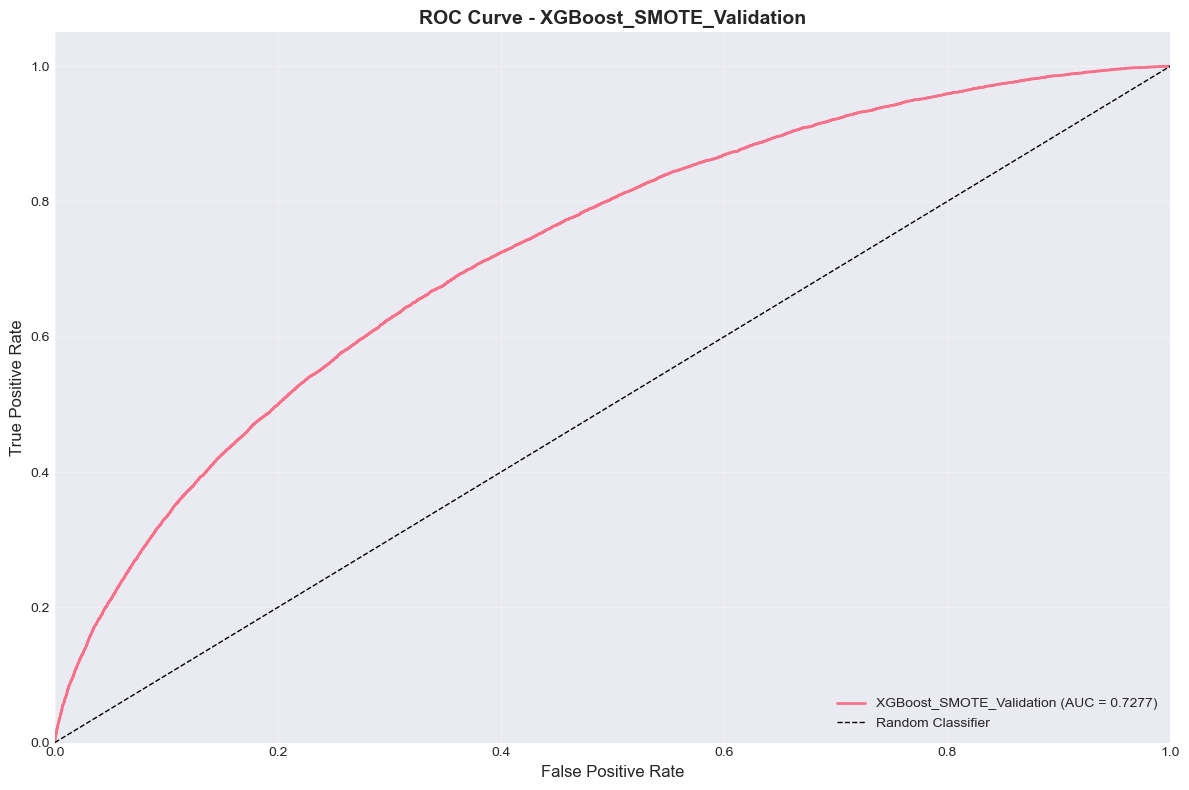

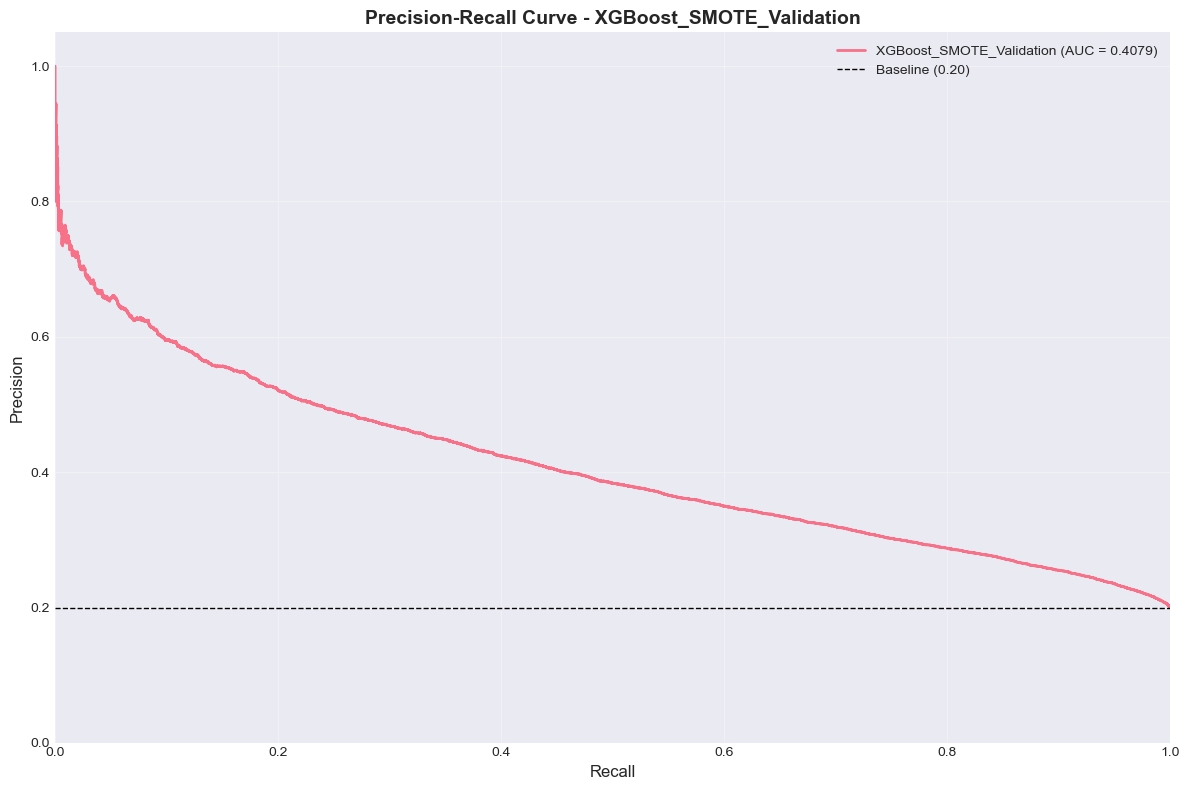

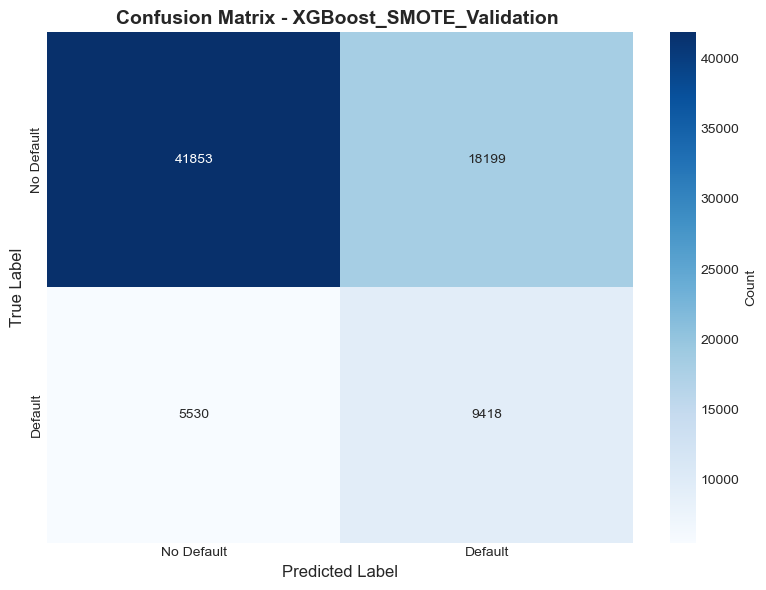

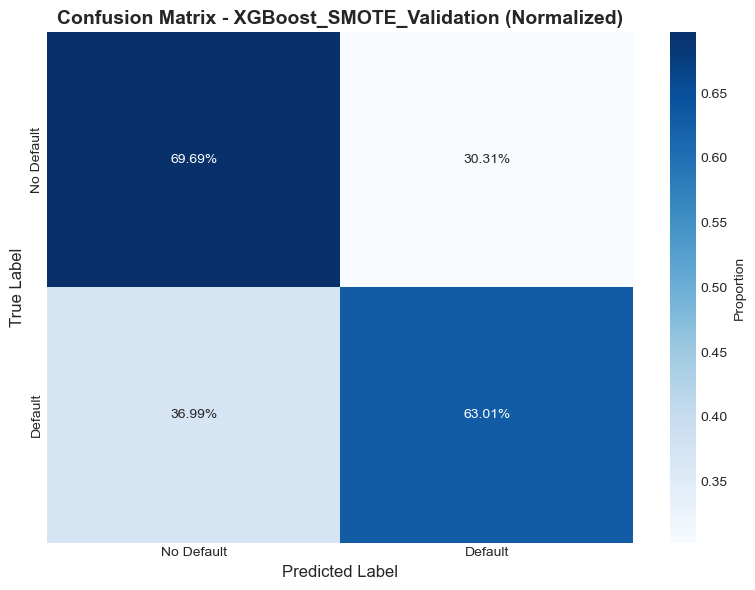

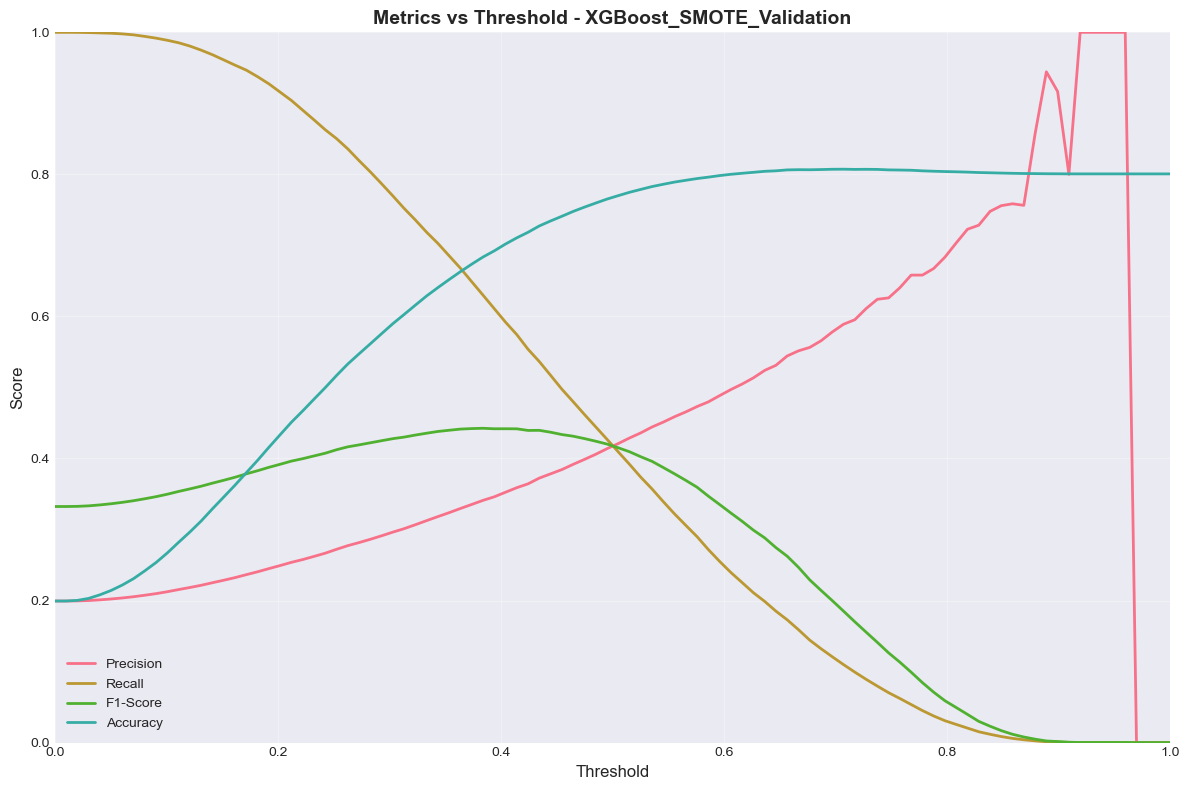

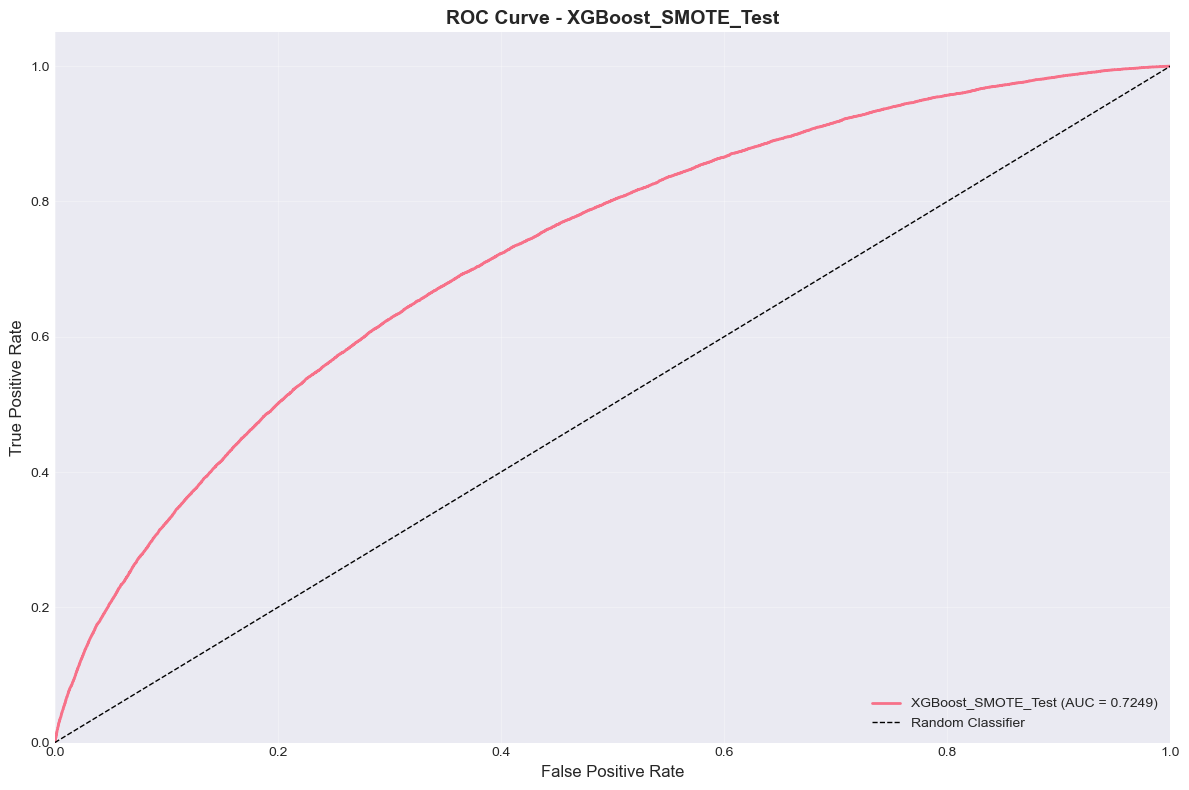

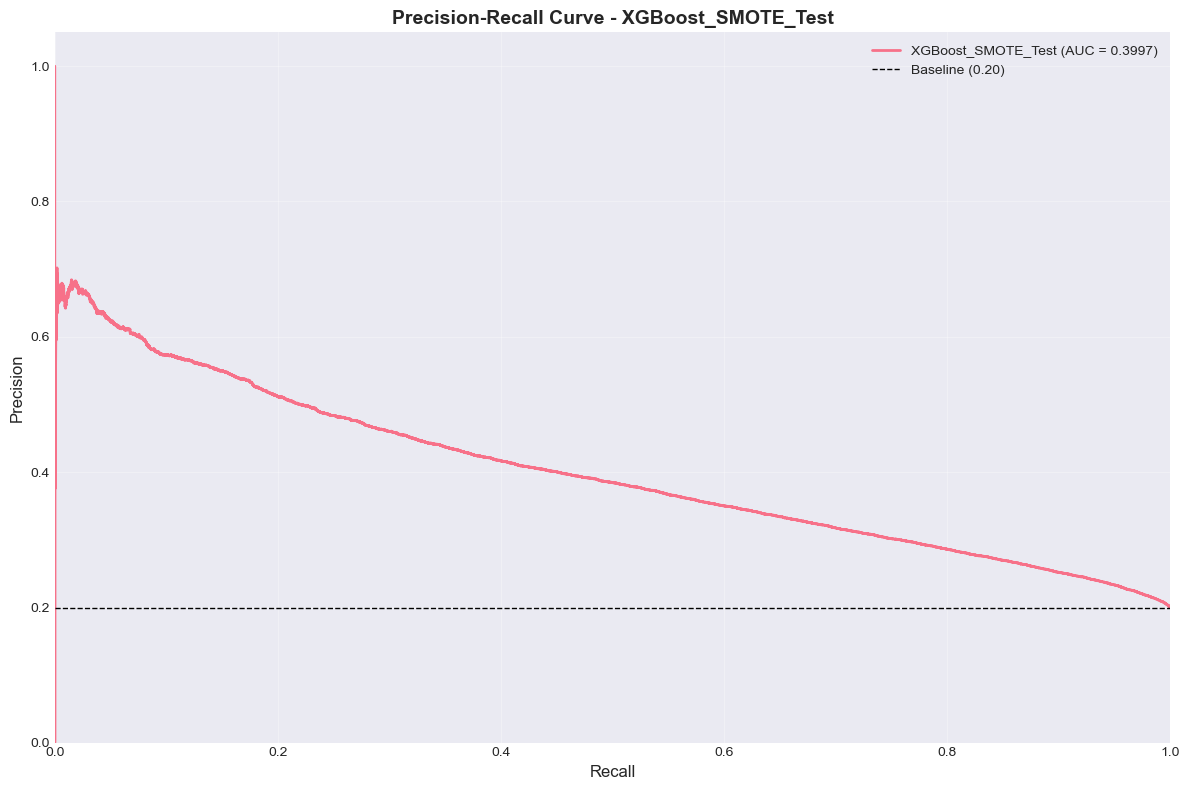

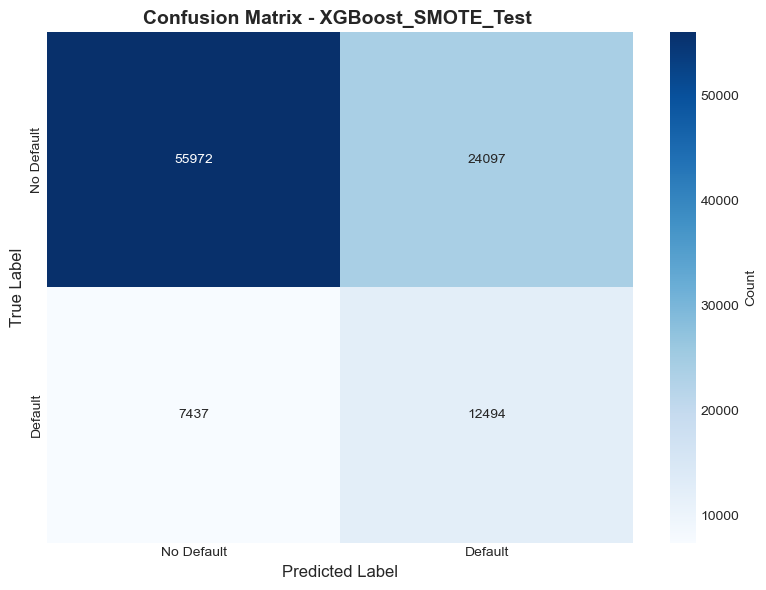

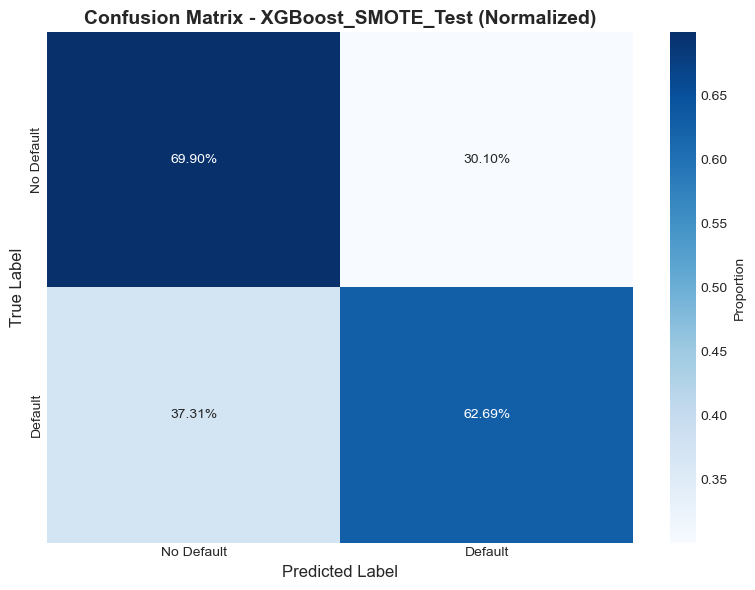

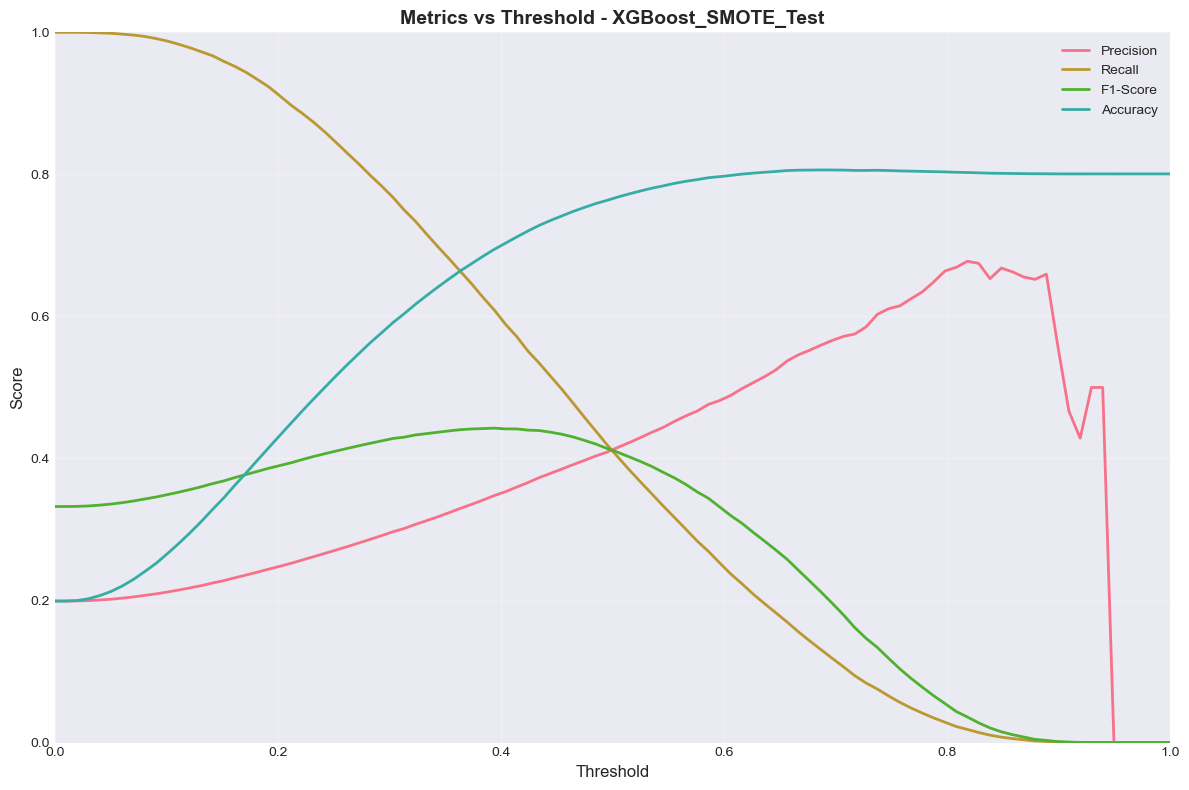

In [10]:
print("Generating evaluation plots...")

val_figures = evaluator.evaluate_all_plots(
    y_val, y_val_proba,
    model_name="XGBoost_SMOTE_Validation",
    threshold=optimal_threshold,
    save=True
)

test_figures = evaluator.evaluate_all_plots(
    y_test, y_test_proba,
    model_name="XGBoost_SMOTE_Test",
    threshold=optimal_threshold,
    save=True
)

print("✓ All plots saved to results/figures/")

## 9. Feature Importance Analysis

In [11]:
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Get feature importance
importance_df = xgb_model.get_feature_importance()

print("\nTop 20 Most Important Features:\n")
print(importance_df.head(20).to_string(index=False))


FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:

              feature  importance
                 term 2429.388428
  high_loan_to_income  947.258606
       home_ownership  398.914795
        income_bucket  294.660858
         inquiry_risk  191.426758
  recent_inquiry_rate  182.017715
       inq_last_6mths  162.084610
     loan_amnt_bucket  153.449799
   num_tl_op_past_12m  137.910278
       fico_range_low  136.498718
  initial_list_status  119.699341
 acc_open_past_24mths   99.845795
      fico_range_high   82.333824
             mort_acc   54.290638
        fico_dti_risk   53.167679
              purpose   48.233498
  num_rev_tl_bal_gt_0   33.860195
mths_since_recent_inq   26.583101
       num_actv_bc_tl   23.424250
                  dti   22.993303


## 10. Summary

In [12]:
from sklearn.metrics import confusion_matrix

print("="*80)
print("MODEL TRAINING SUMMARY")
print("="*80)

print(f"\n📊 DATASET INFORMATION:")
print(f"  Training samples: {len(X_train):,} (SMOTE-balanced)")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {X_train.shape[1]}")
print(f"  SMOTE ratio: {train_dist[0]/train_dist[1]:.2f}:1")

print(f"\n🎯 TEST SET PERFORMANCE:")
print(f"  AUC-ROC: {test_metrics['roc_auc']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.4f}")
# Calculate True Positive Rate (TPR, aka Recall) and False Positive Rate (FPR) for test set
# y_test and y_test_pred are assumed to be available, as well as optimal_threshold, y_test_proba

y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

print(f"  TPR (Recall): {tpr:.4f}")
print(f"  FPR: {fpr:.4f}")

print(f"\n💾 SAVED ARTIFACTS:")
print(f"  Model: {model_path}")
print(f"  Figures: results/figures/")

print(f"\n✅ TRAINING COMPLETE!")
print("="*80)

MODEL TRAINING SUMMARY

📊 DATASET INFORMATION:
  Training samples: 364,313 (SMOTE-balanced)
  Validation samples: 75,000
  Test samples: 100,000
  Features: 103
  SMOTE ratio: 2.50:1

🎯 TEST SET PERFORMANCE:
  AUC-ROC: 0.7249
  Precision: 0.3415
  Recall: 0.6269
  F1-Score: 0.4421
  Optimal Threshold: 0.3838
  TPR (Recall): 0.6269
  FPR: 0.3010

💾 SAVED ARTIFACTS:
  Model: c:\Users\Faheem\Desktop\Umair FYP\FYP2025\credit_risk_fyp\models\xgboost_smote_improved.pkl
  Figures: results/figures/

✅ TRAINING COMPLETE!
